## ForestClassifier from SAS® Viya® on Customer Churn Data Set

### About the [Churn Dataset](https://archive.ics.uci.edu/dataset/563/iranian+churn+dataset) 

This dataset was randomly collected from an Iranian telecom company's database over a 12-month period. It comprises 3150 rows, each representing a customer, with information across 13 columns. The dataset includes attributes such as call failures, SMS frequency, number of complaints, distinct calls, subscription length, age group, charge amount, service type, usage duration, status, usage frequency, and Customer Value.

All attributes, except for the churn attribute, consist of aggregated data from the first 9 months. The churn labels indicate the customers' status at the end of the 12-month period. The three-month gap is designated for planning purposes.

### Import libraries 

In [10]:
import os
import pandas as pd
from sklearn import metrics
from sklearn.metrics import accuracy_score, auc, roc_curve, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import matplotlib.pyplot as plt

from sasviya.ml.tree import ForestClassifier

### Import customer churn data set

In [11]:
workspace=f'{os.path.abspath("")}/../../data/'
churn_df=pd.read_csv(workspace+'churn.csv')
churn_df.head(5)

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0


### Split the data 

When training any supervised learning model, it is important to split the data into training and test data. The training data is used to fit the model. The algorithm uses the training data to learn the relationship between the features and the target. The test data is used to evaluate the performance of the model.

The code below splits the data into separate variables for the features and target, then splits into 80% training and 20% test data.

In [12]:
X_df = churn_df.drop('Churn', axis=1)
y = churn_df['Churn']  

X_train, X_test, y_train, y_test = train_test_split(X_df, y, stratify=y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2520, 13), (630, 13), (2520,), (630,))

### Fit and evaluate the forest model

First, we instantiate the Forest model with default parameters. Subsequently, we train the model using our training data by providing both the features and the target variable, enabling the model to learn.

For details about using the `ForestClassifier` class in the `sasviya` package, see the [ForestClassifier documentation](https://documentation.sas.com/?cdcId=workbenchcdc&cdcVersion=default&docsetId=explore&docsetTarget=p04zhxjh60eutqn1t40f0104gw42.htm).

In [13]:
rf = ForestClassifier(n_estimators=100, 
                      max_depth=5,
                      min_samples_leaf=1,
                      max_features=None,
                      criterion='gini',
                      random_state=0)

rf.fit(X_train, y_train)

ForestClassifier(criterion="gini", max_depth=5, min_samples_leaf=1, random_state=0)

At this stage, we have a trained Forest model; next, we need to determine if it is making accurate predictions.

In [14]:
y_pred = rf.predict(X_test)

The simplest way to evaluate this model is by using accuracy. We compare the predictions with the actual values in the test set and tally the number of correct predictions made by the model.

In [15]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", '{:.4f}'.format(accuracy))
print("Precision:", '{:.4f}'.format(precision))
print("Recall:", '{:.4f}'.format(recall))

Accuracy: 0.9254
Precision: 0.8421
Recall: 0.6465


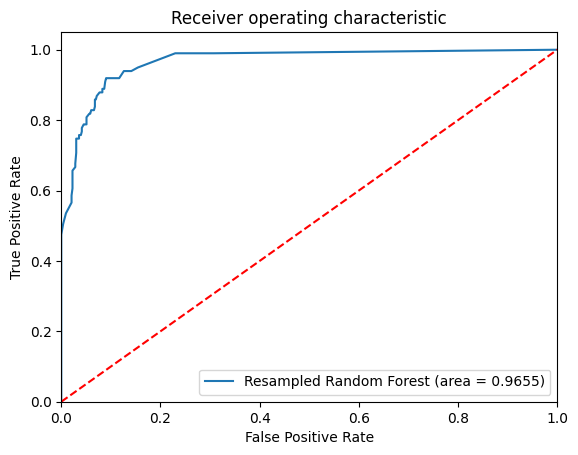

In [16]:
probs = rf.predict_proba(X_test).to_numpy()
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Resampled Random Forest (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

This is a commendable score! Nevertheless, we might achieve even better results by optimizing our hyperparameters.

### Hyperparameter Tuning
The code snippet below utilizes Scikit-Learn’s **RandomizedSearchCV**, which conducts a random search for parameters within specified ranges for each hyperparameter. We define the hyperparameters to be used and their respective ranges in the param_dist dictionary. In this scenario, we are utilizing:
* **n_estimators**: the number of decision trees in the forest. Increasing this hyperparameter typically enhances the model's performance, albeit at the cost of increased computational resources for training and prediction.
* **max_depth**: the maximum depth of each decision tree in the forest. Setting a higher value for max_depth can result in overfitting, while setting it too low may lead to underfitting.

In [17]:
param_dist = {'n_estimators': randint(100,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = ForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=ForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3b31de5bd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f3b567aafd0>})

RandomizedSearchCV will train multiple models (determined by n_iter_) and save each one as variables. The code snippet below creates a variable for the best model and displays the hyperparameters. In this instance, we have not specified a scoring metric for the function, so it defaults to accuracy. Additionally, this function employs cross-validation, where the data is divided into five equally sized groups, using four for training and one for testing. It iterates through each group, providing an accuracy score that is averaged to determine the best model.

In [18]:
# Create a variable for the best modelmetrics
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 118}


### More Evaluation Metrics

Now, let's examine the confusion matrix. This matrix illustrates the model's predictions compared to the actual correct predictions. It helps us grasp the balance between false positives (top right) and false negatives (bottom left). We can visualize the confusion matrix using the following code.

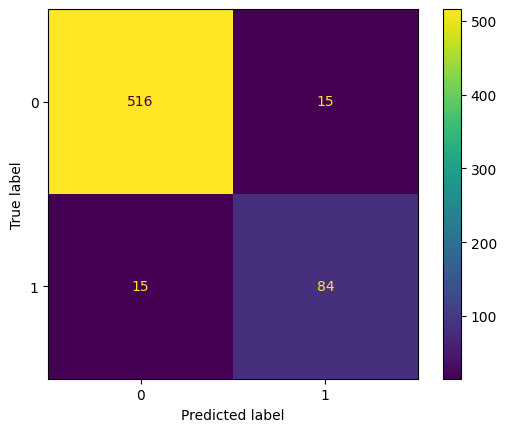

In [19]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test).astype(type(y_test[0]))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

It is advisable to assess the best model using accuracy, precision, and recall. Please note that your results may vary due to randomization.

In [20]:
y_pred = best_rf.predict(X_test).astype(type(y_test[0]))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", '{:.4f}'.format(accuracy))
print("Precision:", '{:.4f}'.format(precision))
print("Recall:", '{:.4f}'.format(recall))

Accuracy: 0.9524
Precision: 0.8485
Recall: 0.8485


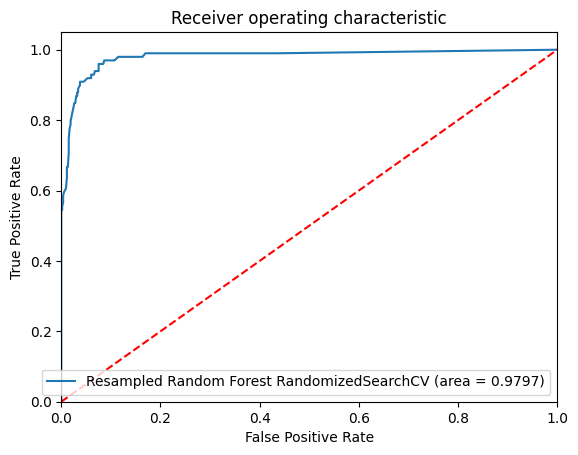

In [21]:
probs = best_rf.predict_proba(X_test).to_numpy()
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Resampled Random Forest RandomizedSearchCV (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Feature Importance

The code below visualizes the importance of each feature by utilizing the model's internal score to determine the optimal way to split the data within each decision tree.

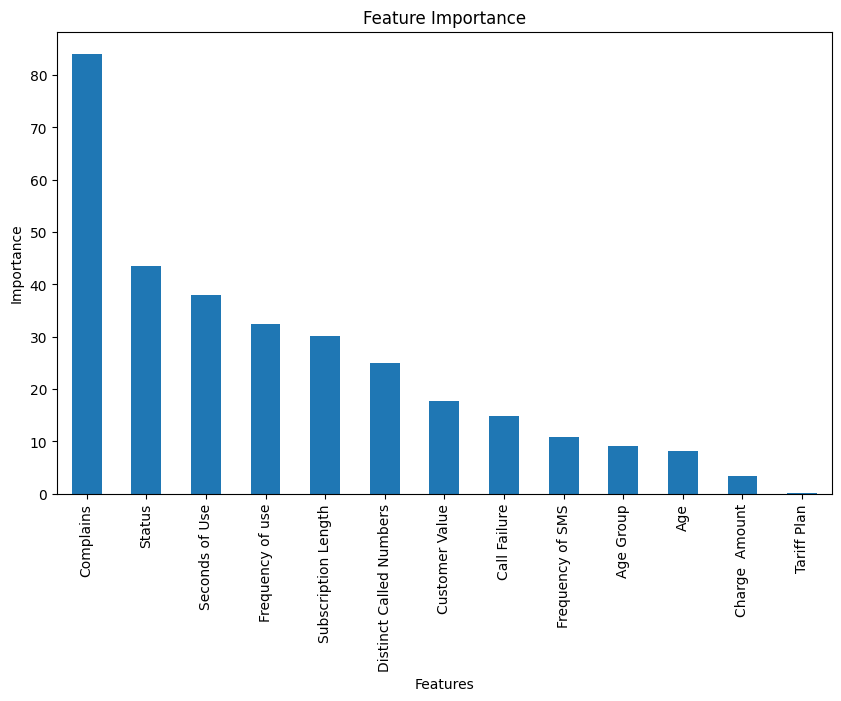

In [22]:
# Generate a series that includes feature importances from the model and feature names from the training data
feature_importances = best_rf.feature_importances_.set_index('Variable')['Importance']

# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width (10) and height (6) as desired

# Plot a simple bar chart
feature_importances.plot.bar();

# Add labels and title
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance');